In [1]:
import warnings 
warnings.filterwarnings("ignore")

In [2]:
import os
import glob
import cv2
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
from skimage.io import imread, imsave
from skimage.transform import resize 
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg16, ResNet50 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import SGD, Adam, RMSprop

import tensorflow.keras.backend as K
# import tensorflow_datasets as tfds
# import tensorflow_hub as hub

# import imgaug as ia
# from imgaug import augmenters as iaa

In [10]:
train_dir='C:/Users/anupa/Downloads/Phase-1/Tongue/Train'
validation_dir='C:/Users/anupa/Downloads/Phase-1/Tongue/Val'
train_cancer=os.path.join(train_dir,'Cancer')
train_noncancer=os.path.join(train_dir,'Non Cancer')
val_cancer=os.path.join(validation_dir,'Cancer')
val_noncancer=os.path.join(validation_dir,'Non-Cancer')

In [11]:
train_c=os.listdir(train_cancer)
train_nc=os.listdir(train_noncancer)
val_c=os.listdir(val_cancer)
val_nc=os.listdir(val_noncancer)

print(len(train_c))
print(len(train_nc))
print(len(val_c))
print(len(val_nc))

95
185
31
63


In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale = 1./255.,
    rotation_range = 40,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True
)

test_datagen = ImageDataGenerator(
    rescale = 1./255.
)

In [13]:

train_generator = train_datagen.flow_from_directory(
    train_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
) 

validation_generator =  test_datagen.flow_from_directory(
    validation_dir,
    batch_size=10,
    class_mode='binary',
    target_size=(150,150)
)

Found 280 images belonging to 2 classes.
Found 94 images belonging to 2 classes.


In [14]:
def build_model():
    base_model = ResNet50(input_shape=(224,224,3), weights='imagenet', include_top=False)
    output = layers.GlobalAveragePooling2D()(base_model.output)
    # av1 = layers.Flatten()(base_model.output)
    fc1 = layers.Dense(128,activation='relu')(output)
    d1 = layers.Dropout(0.6)(fc1)
    output = layers.Dense(2, activation='softmax')(d1)
    model = Model(base_model.input, output)

    for layer in base_model.layers[:-4]:
        layer.trainable=False

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='sparse_categorical_crossentropy', 
                    optimizer=optimizer, 
                    metrics=['accuracy'])

    model.summary()
    
    return model

In [15]:
model=build_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [16]:
history = model.fit_generator(train_generator,
                              steps_per_epoch=4,
                              epochs=20,
                              verbose=1,
                              validation_data = validation_generator,
                              validation_steps=4,)

Epoch 1/20
4/4 [==============================] - 16s 682ms/step - loss: 1.5001 - accuracy: 0.5750 - val_loss: 0.6332 - val_accuracy: 0.7250
Epoch 2/20
4/4 [==============================] - 1s 282ms/step - loss: 0.7658 - accuracy: 0.5500 - val_loss: 0.8915 - val_accuracy: 0.3500
Epoch 3/20
4/4 [==============================] - 1s 279ms/step - loss: 0.7498 - accuracy: 0.5500 - val_loss: 0.6492 - val_accuracy: 0.7000
Epoch 4/20
4/4 [==============================] - 1s 290ms/step - loss: 0.5567 - accuracy: 0.7000 - val_loss: 0.5361 - val_accuracy: 0.7250
Epoch 5/20
4/4 [==============================] - 1s 281ms/step - loss: 0.3980 - accuracy: 0.8750 - val_loss: 0.5571 - val_accuracy: 0.7500
Epoch 6/20
4/4 [==============================] - 1s 274ms/step - loss: 0.4898 - accuracy: 0.7750 - val_loss: 0.6346 - val_accuracy: 0.7250
Epoch 7/20
4/4 [==============================] - 1s 277ms/step - loss: 0.5035 - accuracy: 0.7500 - val_loss: 1.2017 - val_accuracy: 0.3250
Epoch 8/20
4/4 [===

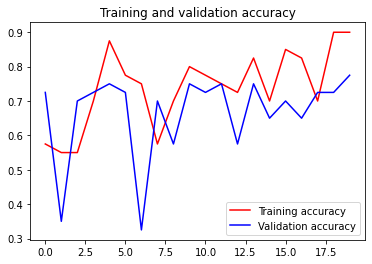

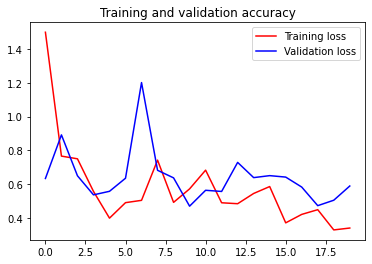

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.legend(loc=0)
plt.title('Training and validation accuracy')

plt.show()

# Model Intrerpreatibility

In [18]:
outputs = [layer.output for layer in model.layers[1:18]]
vis_model = Model(model.input, outputs)
layer_names = []
for layer in outputs:
    layer_names.append(layer.name.split("/")[0])
    print("Layers that will be used for visualization: ")
    print(layer_names)

Layers that will be used for visualization: 
['conv1_pad']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv', 'conv1_bn']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', 'conv2_block1_1_conv', 'conv2_block1_1_bn']
Layers that will be used for visualization: 
['conv1_pad', 'conv1_conv', 'conv1_bn', 'conv1_relu', 'pool1_pad', 'pool1_pool', '

In [19]:
def get_CAM(processed_image, actual_label, layer_name='block5_conv3'):
    model_grad = Model([model.inputs], 
                       [model.get_layer(layer_name).output, model.output])
    
    with tf.GradientTape() as tape:
        conv_output_values, predictions = model_grad(processed_image)

        tape.watch(conv_output_values)
        pred_prob = predictions[:,1] 
        
        actual_label = tf.cast(actual_label, dtype=tf.float32)
        
        smoothing = 0.00001 
        
        loss = -1 * (actual_label * tf.math.log(pred_prob + smoothing) + (1 - actual_label) * tf.math.log(1 - pred_prob + smoothing))
        print(f"binary loss: {loss}")
    
    grads_values = tape.gradient(loss, conv_output_values)
    grads_values = K.mean(grads_values, axis=(0,1,2))
    
    conv_output_values = np.squeeze(conv_output_values.numpy())
    grads_values = grads_values.numpy()

    for i in range(512): 
        conv_output_values[:,:,i] *= grads_values[i]
    heatmap = np.mean(conv_output_values, axis=-1)
    
    heatmap = np.maximum(heatmap, 0)
    heatmap /= heatmap.max()
    
    del model_grad, conv_output_values, grads_values, loss
   
    return heatmap

In [20]:
def show_sample(idx=None):
    if idx:
        for img, label in test_batches.take(idx):
            sample_image = img[0]
            sample_label = label[0]

    else:
        for img, label in test_batches.shuffle(1000).take(1):
            sample_image = img[0]
            sample_label = label[0]
    
    sample_image_processed = np.expand_dims(sample_image, axis=0)
    
    activations = vis_model.predict(sample_image_processed)
    
    pred_label = np.argmax(model.predict(sample_image_processed), axis=-1)[0]
    
    sample_activation = activations[0][0,:,:,16]
    
    sample_activation-=sample_activation.mean()
    sample_activation/=sample_activation.std()
    
    sample_activation *=255
    sample_activation = np.clip(sample_activation, 0, 255).astype(np.uint8)
    
    heatmap = get_CAM(sample_image_processed, sample_label)
    heatmap = cv2.resize(heatmap, (sample_image.shape[0], sample_image.shape[1]))
    heatmap = heatmap *255
    heatmap = np.clip(heatmap, 0, 255).astype(np.uint8)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    converted_img = sample_image.numpy()
    super_imposed_image = cv2.addWeighted(converted_img, 0.8, heatmap.astype('float32'), 2e-3, 0.0)

    f,ax = plt.subplots(2,2, figsize=(15,8))

    ax[0,0].imshow(sample_image)
    ax[0,0].set_title(f"True label: {sample_label} \n Predicted label: {pred_label}")
    ax[0,0].axis('off')
    
    ax[0,1].imshow(sample_activation)
    ax[0,1].set_title("Random feature map")
    ax[0,1].axis('off')
    
    ax[1,0].imshow(heatmap)
    ax[1,0].set_title("Class Activation Map")
    ax[1,0].axis('off')
    
    ax[1,1].imshow(super_imposed_image)
    ax[1,1].set_title("Activation map superimposed")
    ax[1,1].axis('off')
    plt.tight_layout()
    plt.show()
  
    return activations

In [21]:
gap_weights = model.layers[-1].get_weights()[0]
gap_weights.shape

cam_model  = Model(inputs=model.input,outputs=(model.layers[-3].output,model.layers[-1].output))
cam_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [22]:
import scipy as sp
def show_cam(image_value, features, results):
    features_for_img = features[0]
    prediction = results[0]

    # there is only one unit in the output so we get the weights connected to it
    class_activation_weights = gap_weights[:,0]

    # upsample to the image size
    class_activation_features = sp.ndimage.zoom(features_for_img, (224/3,224/3, 1), order=2)
    
    # compute the intensity of each feature in the CAM
    cam_output  = np.dot(class_activation_features,class_activation_weights)

    # visualize the results
    print(f'sigmoid output: {results}')
    print(f"prediction: {'cancer' if round(results[0][0]) else 'non cancer'}")
    plt.figure(figsize=(8,8))
    plt.imshow(cam_output, cmap='jet', alpha=0.5)
    plt.imshow(tf.squeeze(image_value), alpha=0.5)
    plt.show()


In [23]:
# utility function to preprocess an image and show the CAM
def convert_and_classify(image):

  # load the image
  img = cv2.imread(image)

  # preprocess the image before feeding it to the model
  img = cv2.resize(img, (224,224)) / 255.0

  # add a batch dimension because the model expects it
  tensor_image = np.expand_dims(img, axis=0)

  # get the features and prediction
  features,results = cam_model.predict(tensor_image)
  
  # generate the CAM
  show_cam(tensor_image, features, results)


In [26]:
convert_and_classify("C:/Users/anupa/Downloads/Phase-1/Tongue/Train/Non Cancer/nc59.jpg")
# convert_and_classify('nc120.jpg')
# convert_and_classify('nc85.jpg')
# convert_and_classify('nc109.jpg')
# convert_and_classify('nc48.jpg')
# convert_and_classify('nc88.jpg')

RuntimeError: sequence argument must have length equal to input rank